In this notebook, using two different examples, the Auto Regressive Cepstral Coefficients and Real Cepstral Coefficients **are compared** regarding their discriminatory power in grasping the inner patterns of time series.  
Regarding reliable examinations, similar time windows are found using the `stumpy` package. The package is prominent in the time series pattern matching domain and can be referred to as a reference. After finding similar time windows using `stumpy`, I examine the eligibility of cepstral coefficients regarding their ability to discern the underlying patterns of time series. The procedure is as follows:  
1. Find similar pairs of time windows using `stumpy`
2. Calculate the cepstral coefficients of two similar time windows (cc1 and cc2) and a different one (cc3).
3. Calculate the Euclidean distance between each pair of calculated cepstral coefficients (i.e., Euclidean distance between (cc1 and cc3), (cc2, cc3), and (cc1, cc2). Presuming the valid efficiency of cepstral coefficients, I expect $euclidean(cc1, cc2)<euclidean(cc2, cc3)$ and $euclidean(cc1, cc2)<euclidean(cc1, cc3)$).

Two different methods for calculating cepstral coefficients are provided here
- Auto-Regressive Cepstral Coefficients (ARCepstral)
- Real Cepstral Coefficients

# ARCepstral
The cepstrum of an ARIMA time–series can be estimated using the parameters of an ARIMA model for that time–series. Consider a time–series $X_t$ defined by an $AR(p)$ model $X_t+\alpha_1X_{t-1}+\ldots+\alpha_pX_{t-p}=\epsilon_t$ where $\alpha_1+\ldots+\alpha_p$ are the auto-regression coefficients and $\epsilon_t$ is white noise with mean 0 and certain non zero variance. Note that for every ARIMA model, an equivalent AR model can be obtained from the ARIMA model by polynomial division.  
The cepstral coefficients for an $AR(p)$ time–series can be derived from the auto-regression coefficients [[1](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=S.+Furui.+Digital+Speech+Processing%2C+Synthesis%2C+and+Recognition.+Marcel+Deckker%2C+Inc.%2C+New+York%2C+1989.&btnG=)]:
$$
{c_n} = \left\{ {\begin{array}{*{20}{c}}
  { - {\alpha _1},}&{{\text{if n = 1}}} \\ 
  { - {\alpha _n} - \sum\nolimits_{m = 1}^{n - 1} {\left( {1 - \frac{m}{n}} \right){\alpha _m}{c_{n - m}},} }&{{\text{if }}1 < n \leqslant p} \\ 
  { - \sum\nolimits_{m = 1}^p {\left( {1 - \frac{m}{n}} \right){\alpha _m}{c_{n - m}},} }&{{\text{if }}p < n} 
\end{array}} \right.
$$

# Real Cepstral
The real cepstrum is defined as the inverse Fourier transform of the real logarithm of the Fourier transform of the time series [[2](https://doi.org/10.1016/j.eswa.2020.113705
)]. 


# Import the required packages

In [1]:
using PythonCall
using YFinance
stumpy = pyimport("stumpy")
include("../src/CepstralClustering.jl")
using .CepstralClustering
import PythonPlot as plt

# Find similar Time windows using `stumpy`
The daily adjusted close price of the Intel Corporation from **19th October 2018** to **17th March 2020** is fetched using the `YFinance.jl` package. The time series passed to the `stumpy` package to find pairs of similar time windows.

In [2]:
series = get_prices("INTC", startdt="2018-10-19", enddt="2020-03-17")["adjclose"];
prof = stumpy.stump(series, 100)
p = pyconvert(Array, prof);
# Define `euc` function to calculate Euclidean distance between two vector of cepstral coefficients
euc(v1, v2) = (v1.-v2).^2 |> sum |> sqrt
function classifyResult(dists::AbstractVector)
    pos = findall(sortperm(dists).==1) |> only
    if pos==1
        @info "Good"
    elseif pos==2
        @info "Not good"
    else
        @info "Bad"
    end
end;

# 1st example

In [3]:
motif_idx = sortperm(p[:, 1])[100]+1
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])+1
@info pair

[ Info: 251
[ Info: 44


According to the result of the cell above, the **251**th window is similar to the **44**th window.

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


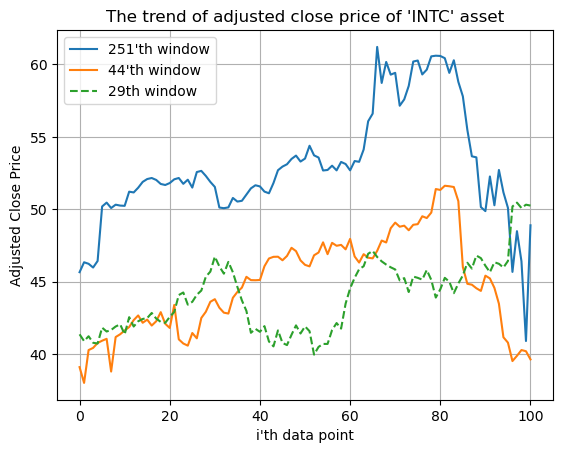

In [4]:
plt.plot(series[motif_idx:motif_idx+100], label="$motif_idx'th window")
plt.plot(series[pair:pair+100], label="$pair'th window")
plt.plot(series[160:160+100], linestyle="--", label="29th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

As can be seen from the figure above, the **251**'th and the **44**'th windows share common patterns in this frame. Thus, it is expected to see the minimum cepstral distance between these two series compared with other possible pairs (i.e., the **29**th and the **251**th windows). 

## ARCepstral

In [5]:
cc1 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[160:160+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.09906116253131712
[ Info: 0.13870923665579826
[ Info: 0.03968405312202358
[ Info: false
[ Info: Not good


❌ The results indicate that the **44**th and **29**th windows are expected to share similar patterns. The figure above shows that the **251**th and **44**th windows share a similar pattern. Thus, the results do not verify the expected outcome.

## Real Cepstral

In [6]:
cc1 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[160:160+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.4992847537552458
[ Info: 0.6911373306562022
[ Info: 0.23157954181056242
[ Info: false
[ Info: Not good


❌ The results show that the **29**th and **44**th windows should share the most similar patterns compared to the other pairs (i.e., the **44**th and **29**th windows). The results can not be testified by the visualization above.

# 2nd example

In [7]:
motif_idx = sortperm(p[:, 1])[75]+1
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])+1
@info pair

[ Info: 229
[ Info: 29


According to the result of the above cell, the **229**th window is similar to the **29**th window. 

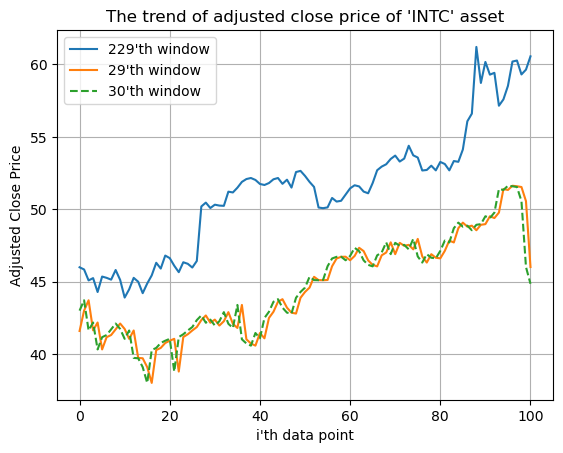

In [8]:
plt.plot(series[motif_idx:motif_idx+100], label="$motif_idx'th window")
plt.plot(series[pair:pair+100], label="$pair'th window")
plt.plot(series[30:30+100], linestyle="--", label="30'th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

As can be seen from the figure above, the **29**th and **30**th windows mirror each other (apparently, since they are two consecutive windows). Thus, expectedly, their cepstral coefficients must have a lower distance from each other compared to the distance from the cepstral coefficients of the **229**'th window.

## ARCepstral

In [9]:
cc1 = cc(ARCepstral, series[30:30+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.004211994937426873
[ Info: 0.06852984062908461
[ Info: 0.07274060157284461
[ Info: true
[ Info: Good


✅ The results is aligned with the expected outcome. According to the visualized series (provided in three cells earlier), the **29**th and **30**th windows have a similar pattern in common. Also, it is expected to have close values for the distance between **229**th and **30**th windows, and the distance between the **229**th and **29**th windows, which can be verified according to the results.

## RealCepstral

In [10]:
cc1 = cc(RealCepstral, series[30:30+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.2519003037588327
[ Info: 0.1983758757878651
[ Info: 0.42233198941983535
[ Info: false
[ Info: Not good


❌ The result does not follow the visualization above. The results indicate that the **229**th and **30**th window have the least distance with each other regarding their real cepstral coefficients. But, it is obvious that the least distance should belong to the **29**th and **30**th windows.

# 3rd example

In [11]:
motif_idx = sortperm(p[:, 1])[208]+1
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])+1
@info pair

[ Info: 94
[ Info: 159


According to the result of the above cell, the **94**th window is similar to the **159**th window. 

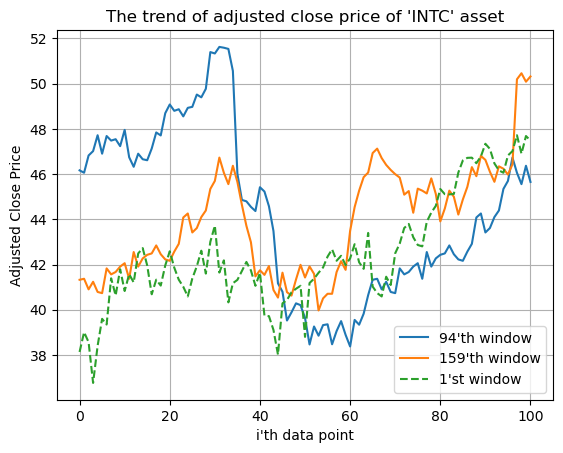

In [12]:
plt.plot(series[motif_idx:motif_idx+100], label="$motif_idx'th window")
plt.plot(series[pair:pair+100], label="$pair'th window")
plt.plot(series[1:1+100], linestyle="--", label="1'st window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

According to the figure above, the **94**th window and **159**th window show similar pattern. The **1**st window can't be considered as a similar window to neither of windows. More precisely, the trend of **1**st window in the interval of **7**th index to **40**th index is nutral. On the other hand, the other two windows have upward trend in that interval.

## ARCepstral

In [13]:
cc1 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[1:1+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.010017623980334048
[ Info: 0.07737727324667111
[ Info: 0.08739075515379692
[ Info: true
[ Info: Good


✅ The result of comparison is in accordance with the illustration above, in which the Euclidean distance between AR cepstral coefficients of **94**th window and cepstral coefficients of **159**th window is less than the other ones.

## RealCepstral

In [14]:
cc1 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[1:1+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.33780977390544253
[ Info: 0.6234454571212644
[ Info: 0.8607363246673304
[ Info: true
[ Info: Good


✅ The outcome of the comparison complies with the visualized comparison which is provided above.

# 4th example

In [15]:
motif_idx = sortperm(p[:, 1])[46]+1
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])+1
@info pair

[ Info: 186
[ Info: 19


According to the result of the above cell, the **186**th window is similar to the **19**th window. 

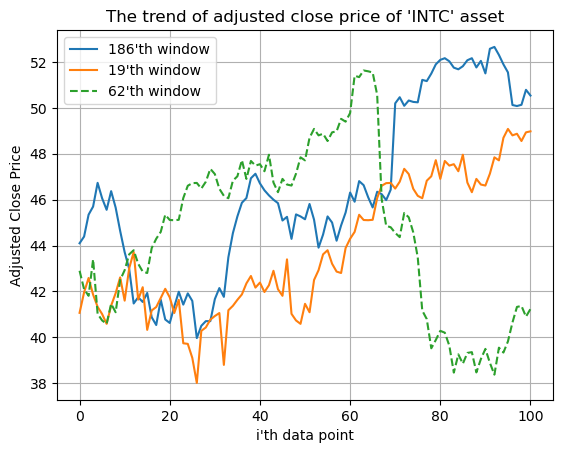

In [16]:
plt.plot(series[motif_idx:motif_idx+100], label="$motif_idx'th window")
plt.plot(series[pair:pair+100], label="$pair'th window")
plt.plot(series[62:62+100], linestyle="--", label="62'th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

## ARCepstral

In [17]:
cc1 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[62:62+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.026230194359523742
[ Info: 0.015909044610416315
[ Info: 0.010321394543709162
[ Info: false
[ Info: Bad


❌ The results doesn't comply with the visualization above. Although I expected the minimum distance between the **186**th window and **19**th window, the results indicate that the **19**th window and **62**th window have the least distance regarding their pattern representatives.

## RealCepstral

In [18]:
cc1 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[62:62+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.8072050069535487
[ Info: 0.12381341722168579
[ Info: 0.7352472158365457
[ Info: false
[ Info: Bad


❌ The outcome of the comparison is against the plot provided above. According to the distances, in this case, the `RealCepstral` method resembels the `ARCepstral` method. Based on the outcome, the **19**th window and **62**th window should a similar pattern in common. This can not get verified since the **186**th and **19**th windows have a more similar pattern compared with any other pair of time windows. 

# 5th example
In this example, I change the interval of the data to test different patterns that was not available in the previously used time span.

In [19]:
series = get_prices("INTC", startdt="2020-10-19", enddt="2022-03-17")["adjclose"];
prof = stumpy.stump(series, 100)
p = pyconvert(Array, prof);

In [20]:
motif_idx = sortperm(p[:, 1])[44]+1
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])+1
@info pair

[ Info: 137
[ Info: 201


According to the result of the above cell, the **137**th window is similar to the **201**th window. 

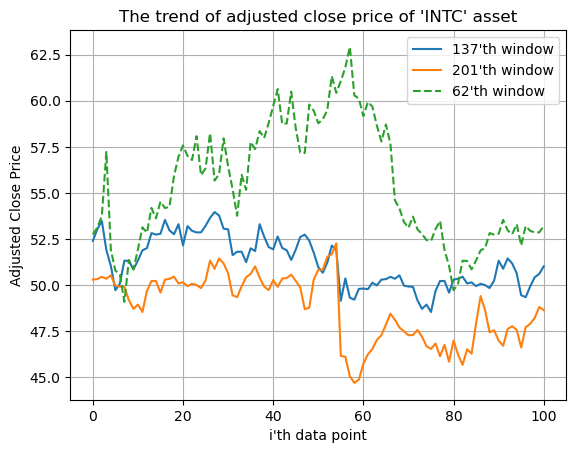

In [21]:
plt.plot(series[motif_idx:motif_idx+100], label="$motif_idx'th window")
plt.plot(series[pair:pair+100], label="$pair'th window")
plt.plot(series[62:62+100], linestyle="--", label="62'th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

## ARCepstral

In [22]:
cc1 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[62:62+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.011163539572176914
[ Info: 0.08028566647088105
[ Info: 0.06912748368971677
[ Info: true
[ Info: Good


✅ The results comply with the visualization above. Expectedly, the minimum distance refers to the distance between the **185**th window and **17**th window.

## RealCepstral

In [23]:
cc1 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[62:62+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc1, cc2)≤euc(cc1, cc3) && euc(cc1, cc2)≤euc(cc2, cc3)
classifyResult([euc(cc1, cc2), euc(cc1, cc3), euc(cc2, cc3)])

[ Info: 0.21182108920894122
[ Info: 0.3290376931012203
[ Info: 0.2001986886024844
[ Info: false
[ Info: Not good


❌ The outcome of the comparison is against the plot provided above. According to the distances, the **201**th window and **62**th window should have a similar pattern in common. This can not get verified since the **137**th and **201**th windows have a more similar pattern compared with any other pair of time windows.

# 6th example

In [24]:
series = get_prices("ALB", startdt="2019-10-19", enddt="2021-03-17")["adjclose"];
prof = stumpy.stump(series, 100)
p = pyconvert(Array, prof);

In [25]:
motif_idx = sortperm(p[:, 1])[216]+1
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])+1
@info pair

[ Info: 71
[ Info: 191


According to the result of the above cell, the **71**th window is similar to the **191**th window. 

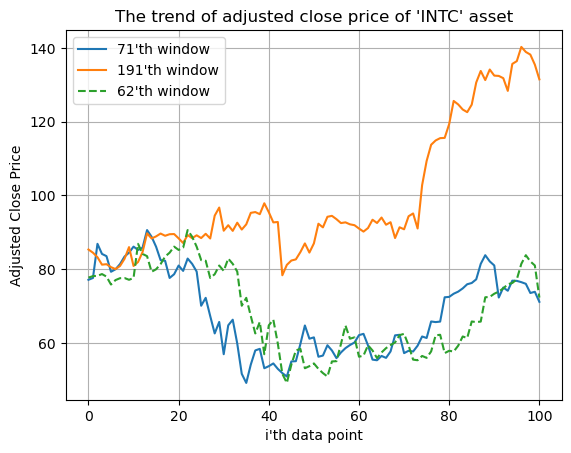

In [26]:
plt.plot(series[motif_idx:motif_idx+100], label="$motif_idx'th window")
plt.plot(series[pair:pair+100], label="$pair'th window")
plt.plot(series[62:62+100], linestyle="--", label="62'th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

## ARCepstral

In [27]:
cc1 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[62:62+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc2, cc3)≤euc(cc1, cc2) && euc(cc2, cc3)≤euc(cc1, cc3)
classifyResult([euc(cc2, cc3), euc(cc1, cc2), euc(cc1, cc3)])

[ Info: 0.09302063377062114
[ Info: 0.004146497008311317
[ Info: 0.08887618119541928
[ Info: false
[ Info: Not good


❌ The results doesn't comply with the visualization above. Although I expected the minimum distance between the **191**th window and **62**th window, the results indicate that the **71**th window and **62**th window have the least distance regarding their pattern representatives, which does not make sense.

## RealCepstral

In [28]:
cc1 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[62:62+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

@info euc(cc2, cc3)≤euc(cc1, cc2) && euc(cc2, cc3)≤euc(cc1, cc3)
classifyResult([euc(cc2, cc3), euc(cc1, cc2), euc(cc1, cc3)])

[ Info: 0.03186343388251007
[ Info: 0.05156430569635963
[ Info: 0.07814084634025548
[ Info: false
[ Info: Bad


❌ The outputs indicate that the **71**th and **191**th windows share similar pattern. This is not true according to the visualization above. The expected output, based on the plot, is to get the minimum distance between cepstral coefficients of **191**th and **62**th windows.

# Conclusion
According to the results, the Real Cepstral method performs better than the AR Cepstral method in presenting the inner patterns of time series through several coefficients. The results can be summarized in a table as follows:  

| #   | `ARCepsrtal`  | `RealCepstral` | Trend   |
| --- | ------------- | -------------- | ------- |
| 1   | ❌ \| Not good | ❌ \| Not good  | 🐂 ➡ 🐻 |
| 2   | ✅ \| Good     | ❌ \| Not good  | 🐂      |
| 3   | ✅ \| Good     | ✅ \| Good      | 🐻 ➡ 🐂 |
| 4   | ❌ \| Not good | ❌ \| Not good  | 🐻 ➡ 🐂 |
| 5   | ✅ \| Good     | ❌ \| Not good  | 🐻      |
| 6   | ❌ \| Not good | ❌ \| Not good  | 🐻 ➡ 🐂 |
| Sum | 3/6           | 1/6            |         |
